In [2]:
import numpy as np
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import cross_validate, StratifiedKFold
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

import shinra_util as util
import bootstrap as bs
import word_entropy
import feature

import warnings
warnings.filterwarnings('ignore')

/usr/local/var/pyenv/versions/3.6.1/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/var/pyenv/versions/3.6.1/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
plt.rcParams['font.family'] = 'IPAGothic'

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
with open("../data/compound_train.json") as f:
    train = json.load(f)['entry']

In [6]:
train_production_dict = util.train2dict(train, attribute="製造方法")

In [7]:
wiki_sentence_df = pd.read_csv("../data/wikitext_split_sentence_with_subtitle.csv")

## Trainデータ作成

In [8]:
train_sentence_df = wiki_sentence_df.loc[wiki_sentence_df._id.isin(train_production_dict.keys())].reset_index(drop=True)
train_sentence_df._id = train_sentence_df._id.astype(str)
train_sentence_df = util.labeling(train_sentence_df, train_production_dict)
train_sentence_df.head()

,_id,sentence,heading,label
0,2662912,ハロン (halon) は、炭化水素の水素原子（一部または全て）がハロゲン原子で置換されたハ...,NO_SUBTITLE,False
1,2662912,ハロゲン化炭化水素 (halogenated hydrocarbon) が語源で、アメリカ陸...,NO_SUBTITLE,False
2,2662912,ハロン類 (halons)、ハロン化合物 (halon compounds) ともいう。,NO_SUBTITLE,False
3,2662912,ハロンに対し、臭素を含まず、ハロゲンがフッ素と塩素のみの化合物を、フロン（クロロフルオロカー...,NO_SUBTITLE,False
4,2662912,ただし、フロンが日本特有の語であるのに対し、ハロンは国際的に通用する名である。,NO_SUBTITLE,False


In [9]:
train_sentence_df.groupby('label').count()

,_id,sentence,heading
label,,,
False,7725,7725,7725
True,500,500,500


## ブートストラップ法で手がかり語抽出→フィルタリング
- いまいち…

In [130]:
parsed_df = pd.read_pickle("../dump/parsed_df.pickle")

In [157]:
bs_model = bs.Bootstrap(parsed_df)
bs_model.run(['得られる'])

loop:  1
clue words count:  50
loop:  2
clue words count:  59
loop:  3
clue words count:  59


In [137]:
bs_model.clue_words

['見られる',
 '行う',
 'ない',
 '変換される',
 '合成される',
 '高い',
 '一つ',
 '示す',
 'できる',
 '呼ばれる',
 'ある',
 '阻害する',
 '使用される',
 'した',
 '引き起こす',
 '化合物である',
 '利用される',
 '生成する',
 '多い',
 '用いられる',
 'なった',
 'なっている',
 '一種である',
 '用いられている',
 'ことが',
 '表される',
 'あり',
 '指定されている',
 '得られる',
 '発生する',
 'ことで',
 '存在する',
 '用いる',
 'なる',
 '与える',
 '作る',
 '持つ',
 'されている',
 'ため',
 '含む',
 '有する',
 '含まれる',
 '分解する',
 '生成される',
 'する',
 '生じる',
 '一種',
 '分類される',
 '得る',
 '該当する',
 'ために',
 '承認された',
 '知られている',
 '形成する',
 '使われる',
 'なり',
 '合成する',
 '報告されている',
 '一つである']

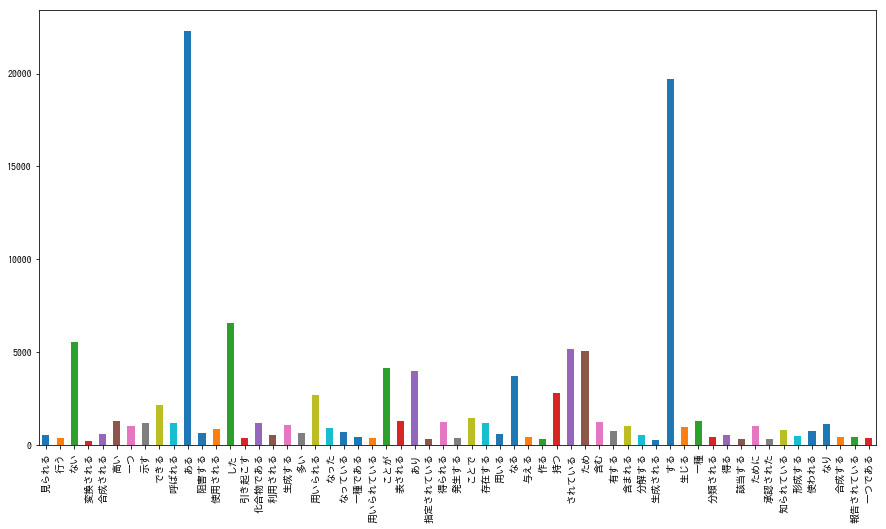

In [158]:
feature_word_dict = {}
for word in bs_model.clue_words:
    feature_word_dict[word] = wiki_sentence_df.sentence.str.contains(util.contains_patt(word)).tolist()

pd.DataFrame(feature_word_dict).T.apply(lambda x: sum(x), axis=1).plot(kind='bar', figsize=(15, 8))

In [159]:
BS_clue_words = bs_model.clue_words.copy()
remove_words = ["ない", "できる", "ある", "した", "ことが", "あり", "ことで", "なる", "されている", "ため", "する", "ために", "なり"]
[BS_clue_words.remove(v) for v in remove_words]

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [160]:
# ブートストラップ法で得た手がかり語で学習データをフィルタリング
print("train length :", len(train_sentence_df))
print("label 1 :", len(train_sentence_df.loc[train_sentence_df.label == 1]), "\tlabel 0 :", len(train_sentence_df.loc[train_sentence_df.label == 0]))

filtering_train_sentence_df = train_sentence_df.loc[train_sentence_df.sentence.str.contains(util.contains_patt(BS_clue_words))].reset_index(drop=True)
print("train length (filtering) :", len(filtering_train_sentence_df))
print("label 1 :", len(filtering_train_sentence_df.loc[filtering_train_sentence_df.label == 1]), "\tlabel 0 :", len(filtering_train_sentence_df.loc[filtering_train_sentence_df.label == 0]))

train length : 8929
label 1 : 500 	label 0 : 8429
train length (filtering) : 3561
label 1 : 306 	label 0 : 3255


## Entropyを用いた手がかり語抽出

In [10]:
is_clue_word = lambda hinshi: (hinshi[0] == "名詞" and hinshi[1] == "サ変接続") or (hinshi[0] == "動詞" and hinshi[1] == "自立")

In [11]:
clue_word_df = \
train_sentence_df.assign(
    clue_word = 
    train_sentence_df.apply(
        lambda x: util.get_word_list(x.sentence, is_clue_word)
        , axis=1
    )
)[["clue_word", "label"]]

In [12]:
clue_word_entropy = word_entropy.word_entropy(clue_word_df)

In [14]:
alpha = 1.1
entropy_clue_words = \
clue_word_entropy[
    (clue_word_entropy.entropy_positive > alpha * clue_word_entropy.entropy_negative) & (clue_word_entropy.entropy_negative > 0)
].clue_word.tolist()
entropy_clue_words

['合成',
 '析出',
 '作ら',
 '生成',
 '還元',
 '熱',
 '抽出',
 '溶かし',
 '通じ',
 '脱',
 '加熱',
 '合さ',
 '中和',
 '濃縮',
 '加える',
 '蒸発',
 '冷却',
 '改良',
 '通す',
 '反応',
 '得る',
 '得',
 '沈殿',
 '発酵']

## 特徴量作成

In [15]:
train_y = train_sentence_df.label.values

In [16]:
# Entropyで得た手がかり語が文中に含まれているかどうか
train_X = feature.contains_clue_word(train_sentence_df, entropy_clue_words + ['製造'])

# サブタイトル中にEntropyで得た手がかり語が含まれているかどうか
train_X["subtitle_cat"] = feature.subtitle_cat(train_sentence_df, entropy_clue_words + ['製造'])

In [17]:
category_in_NITE_df = pd.read_csv("../data/NITE_existence_list.csv")
category_in_NITE_list = category_in_NITE_df.loc[category_in_NITE_df.label == True].category.tolist()
compound_list = pd.read_csv("../data/compound_list.csv").rename(columns={"compound": "name"}).name.tolist()
element_list = pd.read_csv("../data/element_list.csv").name.tolist()

train_X["n_NITE"] = train_sentence_df.sentence.str.findall(util.contains_patt(category_in_NITE_list)).apply(lambda x: len(x))
train_X["n_compound"] = train_sentence_df.sentence.str.findall(util.contains_patt(compound_list)).apply(lambda x: len(x))
train_X["n_element"] = train_sentence_df.sentence.str.findall(util.contains_patt(element_list)).apply(lambda x: len(x))

## 学習

In [18]:
model = lgb.LGBMClassifier(is_unbalance=False)

scores = cross_validate(model, train_X, train_y, scoring=['f1', 'precision', 'recall'], cv=5)

print("f1: ", scores['test_f1'].mean())
print("precision: ", scores['test_precision'].mean())
print("recall: ", scores['test_recall'].mean())

f1:  0.4704503510037938
precision:  0.6329223319053827
recall:  0.378


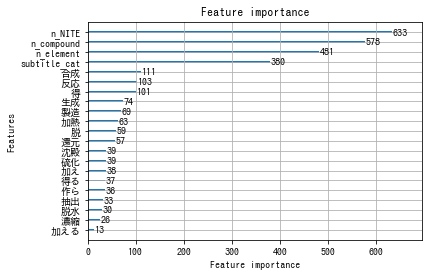

In [18]:
model.fit(train_X, train_y)
lgb.plot_importance(model)

In [19]:
predict = model.predict(train_X)

TP_index = np.where((predict == train_y) & (predict == 1))[0]
TN_index = np.where((predict == train_y) & (predict == 0))[0]
FP_index = np.where((predict != train_y) & (predict == 1))[0]
FN_index = np.where((predict != train_y) & (predict == 0))[0]

print("TP: ", len(TP_index))
print("TN: ", len(TN_index))
print("FP: ", len(FP_index))
print("FN: ", len(FN_index))

TP:  300
TN:  4336
FP:  45
FN:  200


In [20]:
print(train_sentence_df.loc[TP_index, 'sentence'].values)

['6 SCl2 ＋ 16 NH3 → N4S4 ＋ 2 S ＋ 12 NH4Cl 二塩化硫黄の四塩化炭素溶液に塩素を加え、アンモニアを通しても生ずる。'
 '4 SCl2 ＋ 16 NH3 ＋ 2 Cl2 → S4N4 ＋ 12 NH4Cl 二塩化二硫黄の二硫化炭素溶液にアンモニアを作用させてもできる。'
 '四硫化四窒素を真空中で 300 ℃ に加熱すると生じる。'
 '四硫化四窒素を硫黄とともに二硫化炭素中で混合させてオートクレーブ中 110 ℃ に加熱すると生じる。'
 '1,2-グリコール合成を工業的に合成する場合は、アルケンを空気酸化してオキシラン（エポキシド）とし、酸性条件下においてH2O で開環させてジオールとする。'
 '実験室的にはアルケンを四酸化オスミウムで酸化するか、アルケンを低温下で過マンガン酸カリウムと反応させてジオールを得る。'
 '製法は氷冷したフッ化水素酸にアンモニアを通じて析出させるか、塩化アンモニウムとフッ化ナトリウムの混合物または硫酸アンモニウムとフッ化カルシウムの混合物を加熱し，昇華させて得る。'
 '製法は直接アンモニアとフッ化水素の反応生成物を加熱固化するか、同酸、塩基水溶液を混合し蒸発濃縮すると得られる。'
 'クロロホルムはフッ化水素と反応してクロロジフルオロメタンとなり、クロロジフルオロメタンが熱分解してTFEが生成する。'
 '亜塩素酸ナトリウムは塩素酸ナトリウムから間接的に合成される。'
 '始めに爆発性で不安定な二酸化塩素ガスを強酸性溶液中で適当な還元剤（例えば塩化ナトリウム、二酸化硫黄もしくは塩酸）を用いて塩素酸ナトリウムから合成する。'
 '二酸化塩素はそのとき塩基性溶液を吸収し、過酸化水素を還元して亜塩素酸ナトリウムが生じる。'
 'テトラヒドロピランの古典的な有機合成法には、ラネー合金によるジヒドロピランへの水素化がある。'
 '1-プロパノール、プロピオンアルデヒドの酸化によって得られる。'
 '語源は「最初の脂肪酸」という意味で、油脂の加水分解により得られる脂肪酸のうち、最も炭素数の少ないものであったことによる。'
 '炭素数が奇数の脂肪酸はβ酸化により反応が進み、2個ずつの炭素がアセチルCoAとして生成し、最後に炭素数3個のプロピオニルCoAを生じる。'
 '雷酸塩は銀や水銀のような金属を硝酸に

## 原材料の抽出

In [21]:
noun_list = pd.read_csv("../data/noun_list_in_category_and_title.csv")
compound_list = pd.read_csv("../data/compound_list.csv")
material_like_list = list(set(compound_list['compound'].tolist() + noun_list['noun'].tolist()))
wiki_data = util.read_jasonl("../data/ENE_compound_name.txt")

In [22]:
entry_dict = dict([[str(entry['pageid']), entry['title']] for entry in wiki_data])

In [23]:
train_material_dict = util.train2dict(train, '原材料')

In [28]:
def get_material_list(_id: str, sentence: str):
    material_list = util.get_compound_list(sentence)
    material_list = list(set(material_list) - set(entry_dict[str(_id)]))
    return material_list

def get_material_df(predicted: pd.DataFrame):
    material_df = pd.DataFrame()
    for _, row in predicted.iterrows():
        material_df = material_df.append(pd.DataFrame({"_id": row._id, "material": get_material_list(row._id, row.sentence)}))
    
    # 原材料っぽい名詞だけ抽出
    material_df = material_df[material_df['material'].str.contains(util.contains_patt(material_like_list))]
    
    return material_df
    
def df2dict(result: pd.DataFrame, value_column: str):
    return result.groupby('_id')[value_column].apply(lambda x: x.tolist()).to_dict()

def extract_from_dict(train: dict, ids: list):
    return dict([[_id, train[_id]] for _id in ids])

In [233]:
precision = []
recall = []
f1 = []
dsa = []
for train_index, test_index in StratifiedKFold(n_splits=5).split(train_X, train_y):
    X_train, X_test = train_X.loc[train_index], train_X.loc[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]
    
    model.fit(train_X, train_y)
    predict = model.predict(X_test)
    
    predict_true_df = train_sentence_df.loc[test_index][predict]
    material = get_material_df(predict_true_df)
    result = df2dict(material, 'material')
    
    test_ids = train_sentence_df.loc[test_index, '_id'].unique()
    dsa += test_ids.tolist()
    score = util.validation(result, extract_from_dict(train_material_dict, test_ids))
    
    precision.append(score['precision'])
    recall.append(score['recall'])
    f1.append(score['f1'])
    
print("f1: ", np.mean(f1))
print("precision: ", np.mean(precision))
print("recall: ", np.mean(recall))

f1:  0.4872099554008491
precision:  0.5462549048416492
recall:  0.44754239545182245


## 出力

In [19]:
model = lgb.LGBMClassifier(is_unbalance=False)
model.fit(train_X, train_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        is_unbalance=False, learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [20]:
# Entropyで得た手がかり語が文中に含まれているかどうか
X = feature.contains_clue_word(wiki_sentence_df, entropy_clue_words + ['製造'])

# サブタイトル中にEntropyで得た手がかり語が含まれているかどうか
X["subtitle_cat"] = feature.subtitle_cat(wiki_sentence_df, entropy_clue_words + ['製造'])

X["n_NITE"] = wiki_sentence_df.sentence.str.findall(util.contains_patt(category_in_NITE_list)).apply(lambda x: len(x))
X["n_compound"] = wiki_sentence_df.sentence.str.findall(util.contains_patt(compound_list)).apply(lambda x: len(x))
X["n_element"] = wiki_sentence_df.sentence.str.findall(util.contains_patt(element_list)).apply(lambda x: len(x))

In [29]:
predict = model.predict(X)
predict_true_df = wiki_sentence_df[predict]
material = get_material_df(predict_true_df)
result = df2dict(material, 'material')    

In [30]:
with open("../output/material.json", 'w') as f:
    json.dump(result, f)

In [34]:
result_production = df2dict(predict_true_df.rename(columns={"sentence": "production"}), 'production')

In [36]:
with open("../output/production.json", 'w') as f:
    json.dump(result_production, f)